<a href="https://colab.research.google.com/github/Pragati-26/spam_detection/blob/main/spam_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data = pd.read_csv('/content/spam_ham_dataset.csv')
data.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
data.shape

(5171, 4)

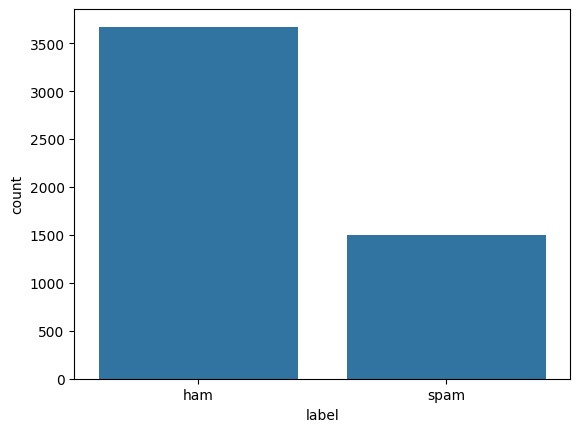

In [ ]:
sns.countplot(x='label' , data=data)
plt.show()

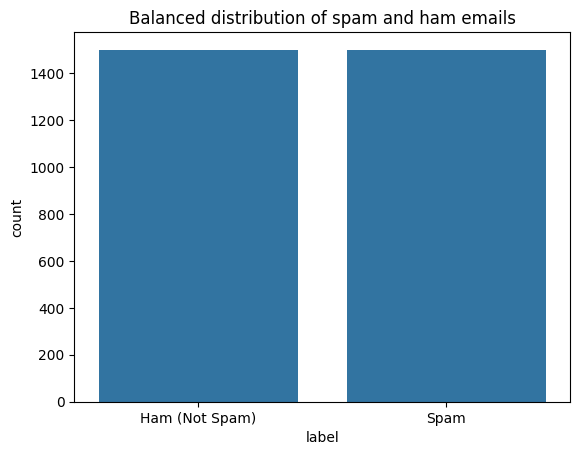

In [ ]:
ham_msg = data[data['label'] == 'ham']
spam_msg = data[data['label'] == 'spam']

# downsample ham emails to match the number of spam emails
ham_msg_balanced = ham_msg.sample(n=len(spam_msg), random_state=42)

#combine balance data
balanced_data = pd.concat([ham_msg_balanced,spam_msg]).reset_index(drop=True)

#visualize the balanced dataset
sns.countplot(x='label', data=balanced_data)
plt.title("Balanced distribution of spam and ham emails")
plt.xticks(ticks=[0,1], labels=['Ham (Not Spam)', 'Spam'])
plt.show()

In [ ]:
# clean the text
balanced_data['text'] = balanced_data['text'].str.replace('subject', '')
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,Subject: conoco - big cowboy\r\ndarren :\r\ni ...,0
1,2982,ham,Subject: feb 01 prod : sale to teco gas proces...,0
2,2711,ham,Subject: california energy crisis\r\ncaliforni...,0
3,3116,ham,Subject: re : nom / actual volume for april 23...,0
4,1314,ham,Subject: eastrans nomination changes effective...,0


In [ ]:
punctuations_list = string.punctuation
def remove_punctuations(text):
  temp = str.maketrans('', '', punctuations_list)
  return text.translate(temp)

balanced_data['text']=balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,Subject conoco big cowboy\r\ndarren \r\ni m ...,0
1,2982,ham,Subject feb 01 prod sale to teco gas processi...,0
2,2711,ham,Subject california energy crisis\r\ncalifornia...,0
3,3116,ham,Subject re nom actual volume for april 23 rd...,0
4,1314,ham,Subject eastrans nomination changes effective ...,0


In [ ]:
def remove_stopwords(text):
  stop_words = stopwords.words('english')

  imp_words = []

  #storing the important words
  for word in str(text).split():
    word = word.lower()
    if word not in stop_words:
      imp_words.append(word)

  output = ' '.join(imp_words)

  return output

balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,Unnamed: 0,label,text,label_num
0,3444,ham,subject conoco big cowboy darren sure help kno...,0
1,2982,ham,subject feb 01 prod sale teco gas processing s...,0
2,2711,ham,subject california energy crisis california  ...,0
3,3116,ham,subject nom actual volume april 23 rd agree ei...,0
4,1314,ham,subject eastrans nomination changes effective ...,0


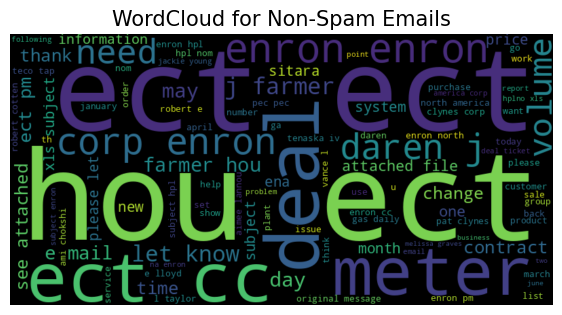

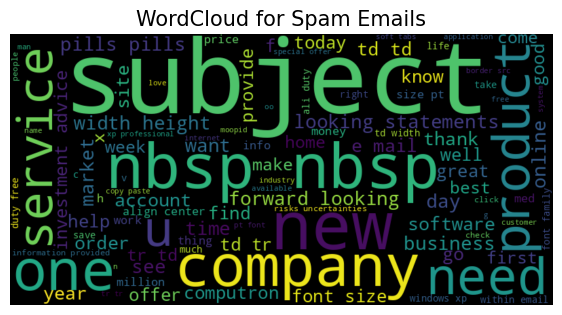

In [ ]:
# Visualization word count

def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
    wc = WordCloud(background_color='black', max_words=100, width=800, height=400).generate(email_corpus)
    plt.figure(figsize=(7, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} Emails', fontsize=15)
    plt.axis('off')
    plt.show()

plot_word_cloud(balanced_data[balanced_data['label'] == 'ham'], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['label'] == 'spam'], typ='Spam')

In [ ]:
# tokenization and padding

train_X , text_X, train_Y,test_Y = train_test_split(balanced_data['text'],balanced_data['label'],test_size=0.2,random_state=42)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)

train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(text_X)

max_len = 100
train_sequences = pad_sequences(train_sequences,maxlen=max_len,padding='post',truncating='post')
test_sequences = pad_sequences(test_sequences,maxlen=max_len,padding='post',truncating='post')

train_Y = (train_Y == 'spam').astype(int)
test_Y = (test_Y == 'spam').astype(int)

In [ ]:
# define the model

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=32, input_length=max_len),
    tf.keras.layers.LSTM(16),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=['accuracy']
)
model.build(input_shape=(None, max_len))
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 32)        │     1,274,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,278,625 (4.88 MB)

 Trainable params: 1,278,625 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# train model

es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(patience=2, monitor='val_loss', factor=0.5, verbose=0)
history = model.fit(
    train_sequences, train_Y,
    validation_data=(test_sequences, test_Y),
    epochs=20,
    batch_size=32,
    callbacks=[lr , es]
)

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - accuracy: 0.5166 - loss: 0.6917 - val_accuracy: 0.8300 - val_loss: 0.4894 - learning_rate: 0.0010
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8867 - loss: 0.3736 - val_accuracy: 0.9550 - val_loss: 0.1645 - learning_rate: 0.0010
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.9634 - loss: 0.1442 - val_accuracy: 0.9600 - val_loss: 0.1657 - learning_rate: 0.0010
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.9747 - loss: 0.1104 - val_accuracy: 0.9617 - val_loss: 0.1665 - learning_rate: 0.0010
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9832 - loss: 0.0838 - val_accuracy: 0.9633 - val_loss: 0.1727 - learning_rate: 5.0000e-04
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9791 - loss: 0.1020 - val_accuracy: 0.9183 - val_loss: 0.2813 - learning_rate: 5.0000e-04
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.9596 - loss: 0.1490 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_sequences,test_Y)
print('test Loss :',test_loss)
print('test Accuracy :',test_accuracy)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9780 - loss: 0.1082
test Loss : 0.12638220191001892
test Accuracy : 0.9733333587646484


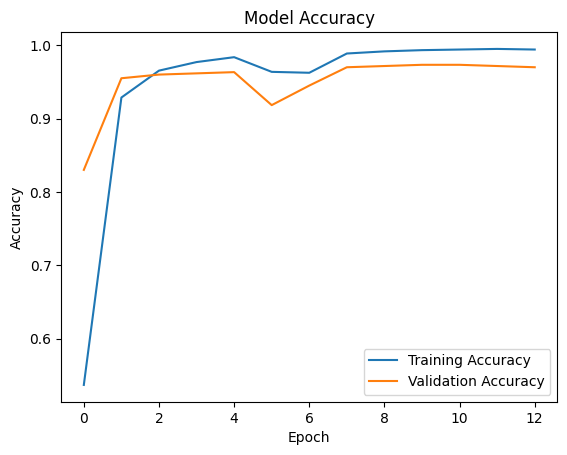

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
import pickle

# Assuming your model and tokenizer are named like this:
pickle.dump(model, open('spam_model.pkl', 'wb'))
# Save the tokenizer instead of a non-existent vectorizer
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))

In [ ]:
model.save("spam_model.h5")


In [31]:
!git init

Reinitialized existing Git repository in /content/.git/


In [32]:
!git commit -m "first commit"

On branch main
nothing to commit, working tree clean


In [34]:
!git remote add origin https://github.com/Pragati-26/spam_detection.git

error: remote origin already exists.


In [37]:
!git add .

In [39]:
!git push -u origin main

fatal: could not read Username for 'https://github.com': No such device or address
